# Skew Trading (가제) 전략 백테스팅

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import calendar
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import norm
from dateutil import relativedelta
from pykrx import stock
from warnings import filterwarnings
filterwarnings('ignore')

c = calendar.Calendar(firstweekday=calendar.SUNDAY)

def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def gamma (option_type, S, K, r, T, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * (sigma ** 2)) * T ) / (sigma * np.sqrt(T))

    return stats.norm.pdf(d1) / (sigma * S * np.sqrt(T))

# def new_next_exp(today):

#     today = dt.datetime.strptime(today, '%Y-%m-%d')

#     next_mon = today + relativedelta.relativedelta(months=1)
#     nnext_mon = next_mon + relativedelta.relativedelta(months=1)

#     if today.day < 15:
#         result = next_mon
#     else:
#         result = nnext_mon
        
#     return result.strftime("%Y%m")

def next_opt_exp(today):

    year = today.year
    month = today.month
    monthcal = c.monthdatescalendar(year,month)
    second_thursday = [day for week in monthcal for day in week if \
                day.weekday() == calendar.THURSDAY and \
                day.month == month][1]

    if today.day<second_thursday.day:
        result= second_thursday
    else:
        result=second_thursday+ relativedelta.relativedelta(months=1)

    return result.strftime("%Y%m")

def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    date = new_next_exp(date)
    base_date = dt.datetime.strptime(date, '%Y%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def tau_creator (today, date):
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    
    return (date - today).days/252

def tau_arr_creator (today, date):

    days = tau_creator(today, date) * 252
    
    return (np.flip(np.arange(0, days+1)) * 1/252).reshape(-1,1)

def delta_cal (s, k, r, q, vol, t):

    def d1_cal (s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))
        
    return norm.cdf(d1_cal(s, k, r, q, vol, t))

def atm_mapping (df, s0):
    '''Option MultiIndex df with spot price'''
    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    atm_k = k_arr[np.where((s0 - k_arr)>0)][-1]

    return atm_k

def otm_mapping (df, s0, mul):

    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    otm_k = k_arr[np.where((s0 * (1 + mul) - k_arr)>0)][-1]

    return otm_k

def d1_cal (s, k, r, q, vol, t):
    return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))

def d2_cal (s, k, r, q, vol, t):
    return d1_cal(s, k, r, q, vol, t) - vol * np.sqrt(t)    

def gamma_cal (s, k, r, q, vol, t):
    
    return norm.pdf(d1_cal(s, k, r, q, vol, t)) / (s*vol*np.sqrt(t))

def theta_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''

    p1 = - s * norm.pdf(d1_cal(s, k, r, q, vol, t))*vol / (2 * np.sqrt(t))
    p2 = r * k * np.exp(-r*t) * norm.cdf(d2_cal(s, k, r, q, vol, t)) 

    if type == 'c':
        return p1 - p2
    else:
        return p1 + p2
    
def vega_cal (s, k, r, q, vol, t):
    return s * np.sqrt(t) * norm.pdf(d1_cal(s,k,r,q,vol,t))

def rho_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''
    if type =='c':
        return k*t*np.exp(-r*t)*norm.cdf(d2_cal(s, k, r, q, vol, t))
    else:
        return -k*t*np.exp(-r*t)*norm.cdf(-d2_cal(s, k, r, q, vol, t))
    
def tmp_dist(price_lst,strike_lst):
    
    window_price = sliding_window_view(price_lst, 3)
    window_strike = sliding_window_view(strike_lst, 3)
    distance = (abs(window_strike[:,2]-window_strike[:,1])+abs(window_strike[:,1]-window_strike[:,0]))/2
    result=window_price[:,0]+window_price[:,2]-2*window_price[:,1]
    return np.round(((result/(distance**2))), 5)

def cal_cost(df):
    return df.iloc[0].item() + df.iloc[2].item() - 2 * df.iloc[1].item()

## 데이터 전처리

In [2]:
import yfinance as yf
kospi200 = yf.download('^KS200', '2005-08-01', '2022-11-30')['Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
file_path = os.getcwd() + '/Data/'

'''현재 에러남 api'''
#kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']

import yfinance as yf
kospi200 = yf.download('^KS200', '2005-08-01', '2022-11-30')['Close']

kospi200_vol = pd.DataFrame(np.log(kospi200).diff().rolling(60).std() * np.sqrt(252)).dropna()
kospi200_vol.index = pd.to_datetime(kospi200_vol.index)
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')


data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [float(x[7:]) for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df

[*********************100%***********************]  1 of 1 completed


cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [4]:
'''코스피'''
kospi_idx = kospi200.loc['2007-12-03':'2022-10-17'].index
idx = kospi_idx[2]
s0 = kospi200.loc[idx]

'''cd금리'''
cd91 = pd.read_csv('./Data/cd91.csv', index_col='Date', parse_dates=True).sort_index()/100
cd91

,CD91
Date,
2001-01-02,0.0688
2001-01-03,0.0687
2001-01-04,0.0677
2001-01-05,0.0668
2001-01-08,0.0666
...,...
2023-04-27,0.0352
2023-04-28,0.0352
2023-05-02,0.0353


## 백테스트용 p_reg, g_reg

In [5]:
g_reg = pd.DataFrame()
p_reg = pd.DataFrame()
p_all_reg = pd.DataFrame()
iv_reg = pd.DataFrame()

for num in tqdm(range(len(kospi_idx))):
#for num in tqdm(range(1900, 3674)):
    
    idx = kospi_idx[num]
    s0 = kospi200.loc[idx]    

    '''전처리용 데이터'''
    test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
    testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

    '''otm 가격'''
    # otm_k_c = otm_mapping(test, s0, 0.08)
    # otm_k_p = otm_mapping(test, s0, -0.08)
    atm_k = atm_mapping(test, s0)
    
    kk = test.columns.get_level_values(2)
    kk_p = kk[np.where((kk < atm_k))]
    kk_pa = kk[np.where((kk < atm_k * 1.2))] 
    kk_c = kk[np.where((kk >= atm_k))]

    iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
    iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

    pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
    pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])

    pr_tmp_all = pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_pa, '종가')])
    pr_tmp_all = pd.DataFrame(data=pr_tmp_all.values, index=pr_tmp_all.index.get_level_values(2).values, columns=[idx])
    
    test_put_iv = iv_tmp[iv_tmp.index <= atm_k]
    test_put_price = pr_tmp[pr_tmp.index <= atm_k]

    #port_comb_c = sliding_window_view(k_list_c, 3)
    port_comb_p = sliding_window_view(test_put_iv.index, 3)
    g_values = tmp_dist(test_put_price.astype(float).to_numpy().reshape(-1), test_put_price.index)

    '''Strike range 잡기'''
    # k_list_c = test.columns.get_level_values(2).unique().values
    # k_list_p = testp.columns.get_level_values(2).unique().values

    # k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
    # k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

    # kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
    # kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values

    '''이때, 하나 줄이기'''
    #g_reg = pd.concat([g_reg, pd.DataFrame(g_values, index=port_comb_p[:,0], columns=[idx])], axis=1)
    g_reg = pd.concat([g_reg, pd.DataFrame(g_values[:-1], index=port_comb_p[:-1,0], columns=[idx])], axis=1).sort_index()
    p_reg = pd.concat([p_reg, test_put_price.sort_index(ascending=True)], axis=1).sort_index()
    p_all_reg = pd.concat([p_all_reg, pr_tmp_all.sort_index(ascending=True)], axis=1).sort_index()
    iv_reg = pd.concat([iv_reg, test_put_iv.sort_index(ascending=True)], axis=1).sort_index()

100%|██████████| 3625/3625 [03:55<00:00, 15.40it/s]


## 포트폴리오 진입, 청산시점 정리

In [24]:
init_port = pd.DataFrame(columns=['port'])

for x in tqdm(g_reg.columns[-1816:]):

    idx = x
    s0 = kospi200.loc[idx]    

    '''필요 df'''
    check = g_reg[idx]
    p_check = p_reg[idx]
    #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

    testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

    '''1. k범위 정하기'''
    #otm_k_c = otm_mapping(test, s0, 0.08)
    otm_k_p = otm_mapping(testp, s0, -0.08)
    atm_k = atm_mapping(testp, s0)

    check_g = g_reg[idx].iloc[np.where(g_reg[idx].index > otm_k_p)[0]].dropna()

    if len(check_g.iloc[np.where(check_g < 0)[0]]) == 0:
        pass
    else:
        
        port_list = []
        
        for new_port in check_g.iloc[np.where(check_g < 0)[0]].index:
            port_list.append(new_port)
        
        init_port.loc[idx, 'port'] = port_list

init_port_list = []

for index in init_port.index:
    for x in init_port.loc[index, 'port']:
        init_port_list.append(index.strftime('%Y%m%d') + str(x))

s_list = []
p_list = []
e_list = []
h_list = []

for x in tqdm(init_port_list):
    check = x

    start_date = dt.datetime.strptime(check[0:8], '%Y%m%d')
    
    portfolio = float(check[8:])
    
    check_g = g_reg.loc[[portfolio]].T.loc[start_date:]
    end_date = check_g.iloc[np.sort(np.append(np.where( (check_g >= 0) )[0], np.where(pd.isna(check_g) == True)[0]))].index[0]
        
    holding_date = int((end_date - start_date).days)

    s_list.append(start_date)
    p_list.append(portfolio)
    e_list.append(end_date)
    h_list.append(holding_date)
    
holding_reg = pd.DataFrame(np.array([s_list, p_list, e_list, h_list]).T, columns=['Start','Port','End','Holdings'])
holding_reg

100%|██████████| 334/334 [00:00<00:00, 1833.16it/s]


,Start,Port,End,Holdings
0,2015-05-19,242.5,2015-05-20,1
1,2015-07-01,235.0,2015-07-02,1
2,2015-08-07,222.5,2015-08-10,3
3,2015-08-24,207.5,2015-08-26,2
4,2015-08-24,212.5,2015-08-25,1
...,...,...,...,...
329,2022-08-08,302.5,2022-08-09,1
330,2022-08-09,307.5,2022-08-10,1
331,2022-09-05,287.5,2022-09-06,1
332,2022-09-27,270.0,2022-09-28,1


### 홀딩기간 Plotting

In [ ]:
# import seaborn as sns 
# plt.figure(figsize=(8, 4), dpi=500)
# plt.title('Holding Period Distribution')
# sns.distplot(holding_all_reg.iloc[507:].Holdings)
# plt.show()

## 날짜별 포트폴리오 진입 기록

In [7]:
'''Backtesting용 Port Start Date'''
aa = holding_reg.set_index('Start')[['Port']]
grouped = aa.groupby(aa.index)
b_df = grouped.apply(lambda x: list(x['Port'])).reset_index(name='Ports')
b_df = b_df.set_index('Start')
b_df

,Ports
Start,
2015-05-19,[242.5]
2015-07-01,[235.0]
2015-08-07,[222.5]
2015-08-24,"[207.5, 212.5]"
2015-08-25,[207.5]
...,...
2022-08-08,[302.5]
2022-08-09,[307.5]
2022-09-05,[287.5]


# BackTesting

## Logic

1. g값이 음수면 포트폴리오 그가격에 구축 가정
2. 포트폴리오 구축 후 다음날 g값 +일때 청산 가정
3. 포트폴리오 구축 시 Moneyness는 0.92% 가정
4. 포트폴리오 청산 시 Moneyness는 고려하지 않음
5. 포트폴리오 청산 시 ATM에서 벗어났을 경우, 바로 청산을 가정 (Loss Cut)


In [8]:
def get_mdd (series):
    '''input Df or Series of one column'''
    array = series   
    max_value = array[0]
    max_drawdown_array = np.zeros_like(array)
    
    for i in range(1, len(array)):
        if array[i] > max_value:
            max_value = array[i]
        else:
            drawdown = (max_value - array[i]) / max_value
            if drawdown > max_drawdown_array[i-1]:
                max_drawdown_array[i] = drawdown
            else:
                max_drawdown_array[i] = max_drawdown_array[i-1]
                
    return pd.DataFrame(-max_drawdown_array * 100, index=series.index, columns=['MDD'])

## 1) 천만원 기준으로 계약당 그당식 가격으로만 사고팔았을때의 누적 수익률

- 첫 구축 비용은 음수이니 돈 받음
- 홀딩 포트폴리오는 반대매매이니 - 붙여서
- 청산 포트폴리오는 가지고 있는 걸 얻게되는 부분이니 + 붙여서

In [9]:
pay_off_df = pd.DataFrame(columns=['Date', 'Balance', 'Assets'])

hold_p = []
balance = 100000
assets = 0
mul = 250000

for x in g_reg.columns[-1816:]:
    
    idx = x
    s0 = kospi200.loc[idx]    
    print('\n')
    print('*********TRADE DATE*********')
    print(idx)
    
    '''포트폴리오 있을 때 체크'''
    print('---------HOLD PORT---------')
    print(hold_p)
    
    if len(hold_p) == 0:
        pass
    else:
        print('---------Individual Hold Port---------')
        for values in hold_p:

            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            price = pd.DataFrame(p_all_reg[idx].loc[inv_port])            
            price = cal_cost(price * mul)
            
            print(f'{values} : {price}')
            
            '''가격 balance에 넣고 빼기'''
            balance += price
            assets += price
            
        '''g값을 확인해서 청산여부 체크하기'''
        print('---------Individual Close Check---------')
        for values in hold_p:            
            
            if g_reg[idx].loc[values] < 0 :
                pass
            
            elif g_reg[idx].loc[values] >= 0 :
                nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                ful_arr = nan_arr[~np.isnan(nan_arr)]
                hold_p = list(ful_arr)
                
                print(f'{values} : {g_reg[idx].loc[values]}')
            
            elif pd.isna(g_reg[idx].loc[values]) == True :
                nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                ful_arr = nan_arr[~np.isnan(nan_arr)]
                hold_p = list(ful_arr)
                
                print(f'{values} : {g_reg[idx].loc[values]}')
                
    '''당일의 포트폴리오 추가'''
    if idx in b_df.index.values:
        print('---------Buying Port Check---------')

        '''포트폴리오 구축 비용 생각 + 저장'''
        for values in b_df.loc[idx].values[0]:
 
            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
            price = cal_cost(price * mul)
            
            print(f'{values} : {price}')
            
            '''포트폴리오에 추가'''
            hold_p.append(values)
            
            '''balance에 추가, 돈 받고 산거임, 따라서 음수'''
            balance += -price
            assets += -price
            
    else:
        pass
    
    '''저장'''
    pay_off_df = pd.concat([pay_off_df, pd.DataFrame([idx, balance, assets], index=['Date', 'Balance', 'Assets']).T])

pay_off_df = pay_off_df.fillna(method='ffill').set_index('Date')
    



*********TRADE DATE*********
2015-05-18 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-19 00:00:00
---------HOLD PORT---------
[]
---------Buying Port Check---------
242.5 : -2500.0


*********TRADE DATE*********
2015-05-20 00:00:00
---------HOLD PORT---------
[242.5]
---------Individual Hold Port---------
242.5 : 0.0
---------Individual Close Check---------
242.5 : 0.0


*********TRADE DATE*********
2015-05-21 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-22 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-26 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-27 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-28 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-29 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-06-01 00:00:00
---------HOLD PORT---------
[]


*********TRADE DA

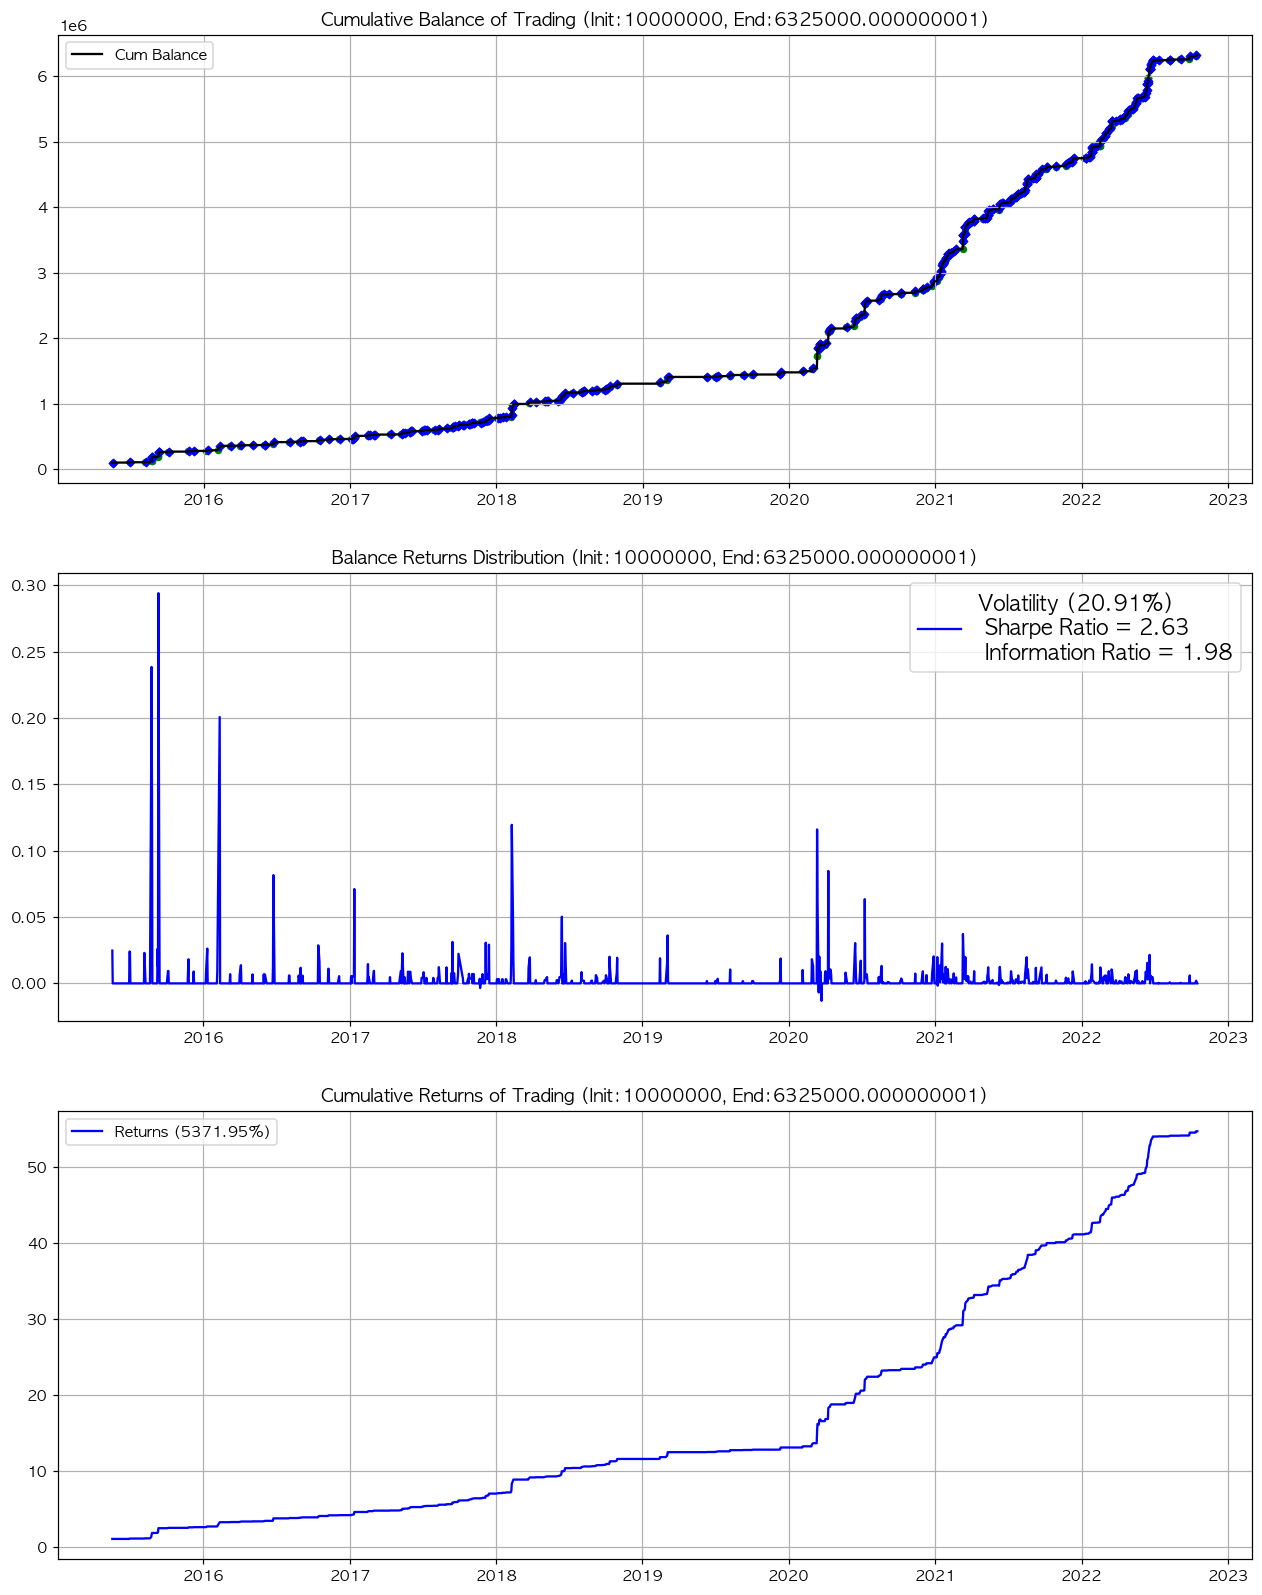

In [ ]:
balance_ret_df = pd.DataFrame(data=np.log(pay_off_df).diff().iloc[1:].Balance.values, columns=['Balance Ret'], index=np.log(pay_off_df).diff().iloc[1:].Balance.index)
bm_ret = pd.DataFrame(np.log(kospi200).diff().dropna().loc[balance_ret_df.index])
rf_ret = cd91.loc[balance_ret_df.index]

ann_std = balance_ret_df.std().item() * np.sqrt(252)

cum_ret_df = np.cumprod(1+balance_ret_df)

sharpe = (balance_ret_df.mean().item() - rf.mean().item()/252) / ((balance_ret_df.values).std()) * np.sqrt(252)
ir_ratio = (balance_ret_df.mean().item() - bm_ret.mean().item()) / (balance_ret_df.values - bm_ret.values).std() * np.sqrt(252)


plt.figure(figsize=(14, 18), dpi=110)
plt.subplot(3,1,1)
plt.title(f'Cumulative Balance of Trading (Init:10000000, End:{balance})')
plt.plot(pay_off_df.Balance, color='k', label=f'Cum Balance')
plt.scatter(x=holding_reg.Start, y=pay_off_df.Balance.loc[holding_reg.Start.values], color='g', marker='o', s=15)
plt.scatter(x=holding_reg.End, y=pay_off_df.Balance.loc[holding_reg.End.values], color='b', marker='D', s=15)
plt.legend()
plt.grid()


plt.subplot(3,1,2)
plt.title(f'Balance Returns Distribution (Init:10000000, End:{balance})')
plt.plot(balance_ret_df, color='b', \
         label=f'Volatility ({np.round(ann_std * 100, 2)}%)\n Sharpe Ratio = {np.round(sharpe, 2)}\n Information Ratio = {np.round(ir_ratio, 2)}')
plt.legend(fontsize=14)
plt.grid()


plt.subplot(3,1,3)
plt.title(f'Cumulative Returns of Trading (Init:10000000, End:{balance})')
plt.plot(cum_ret_df, color='b', label=f'Returns ({np.round( (cum_ret_df.iloc[-1].item()-1)* 100, 2)}%)')
plt.legend()
plt.grid()
plt.show()



## 2) Exposure 조절을 활용한 Back Testing

Holding Port 맥스 4

각 portfolio별 100만원씩 해서 Exposing한다고 생각하면 됨

우리가 Hold하고 나갈 Port 갯수는 조절 가능

매수 증거금 : 지정가 * 주문수량 * 거래승수 이므로 100만뭔이 됨 (산것들은 100만원) <br>
매도 증거금 : max(최대손실옵션 이론가격 - 옵션 기준가격, 옵션조정이론가격(극단 상승, 하락 옵션 이론가) - 옵션증거금기준가격) * 0.3) * 주문수량 * 거래승수

러프하게

In [10]:
def buying_ratio_cal(index, inv_port, budget, mul):
    
    '''1000만원 Exposure 맞추기 / 사서 받는 비용'''
    
    ratio = p_all_reg[index].loc[inv_port].sum() * 250000
    buying_num = int(np.floor(budget/ratio))
    
    price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
    price = cal_cost(price * mul)
    
    return ratio * buying_num, buying_num * price, buying_num

In [11]:
pay_off_df = pd.DataFrame(columns=['Date', 'Balance', 'Assets'])

hold_p = []
balance = 100000000
budget = 2000000
assets = 0
mul = 250000

for x in g_reg.columns[-1816:]:
    
    idx = x
    s0 = kospi200.loc[idx]    
    print('\n')
    print('*********TRADE DATE*********')
    print(idx)
    
    '''포트폴리오 있을 때 체크'''
    print('---------HOLD PORT---------')
    print(hold_p)
    
    if len(hold_p) == 0:
        pass
    else:
        print('---------Individual Hold Port---------')
        for values_str in hold_p:
            
            values = float(values_str.split('|')[0])
            num = int(values_str.split('|')[1])

            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            price = pd.DataFrame(p_all_reg[idx].loc[inv_port])            
            price = cal_cost(price * mul)
            
            price = price * num
            
            print(f'{values} : {price}')
            
            '''가격 balance에 넣고 빼기'''
            balance += price
            assets += price
            
        '''g값을 확인해서 청산여부 체크하기'''
        print('---------Individual Close Check---------')
        for values_str in hold_p:
            
            values = float(values_str.split('|')[0])
            num = int(values_str.split('|')[1])
            
            if g_reg[idx].loc[values] < 0 :
                pass
            
            elif g_reg[idx].loc[values] >= 0 :
                # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                # ful_arr = nan_arr[~np.isnan(nan_arr)]
                # hold_p = list(ful_arr)
                
                hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                hold_p.pop(hold_p_idx)

                print(f'{values} : {g_reg[idx].loc[values]}')
            
            elif pd.isna(g_reg[idx].loc[values]) == True :
                
                # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                # ful_arr = nan_arr[~np.isnan(nan_arr)]
                # hold_p = list(ful_arr)
                
                hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                hold_p.pop(hold_p_idx)
                
                print(f'{values} : {g_reg[idx].loc[values]}')
                
    '''당일의 포트폴리오 추가'''
    if idx in b_df.index.values:
        print('---------Buying Port Check---------')

        '''포트폴리오 구축 비용 생각 + 저장'''
        for values in b_df.loc[idx].values[0]:
 
            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            
            # price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
            # price = cal_cost(price * mul)
            
            margin, price, num = buying_ratio_cal(idx, inv_port, budget, mul)
            
            print(f'{values} : {price} / {num}')
            
            '''포트폴리오에 추가'''
            hold_p.append(str(values) + str('|') + str(num))
            
            '''balance에 추가, 돈 받고 산거임, 따라서 음수'''
            balance += -price
            assets += -price
            
    else:
        pass
    
    '''저장'''
    pay_off_df = pd.concat([pay_off_df, pd.DataFrame([idx, balance, assets], index=['Date', 'Balance', 'Assets']).T])

pay_off_df = pay_off_df.fillna(method='ffill').set_index('Date')
    



*********TRADE DATE*********
2015-05-18 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-19 00:00:00
---------HOLD PORT---------
[]
---------Buying Port Check---------
242.5 : -85000.0 / 34


*********TRADE DATE*********
2015-05-20 00:00:00
---------HOLD PORT---------
['242.5|34']
---------Individual Hold Port---------
242.5 : 0.0
---------Individual Close Check---------
242.5 : 0.0


*********TRADE DATE*********
2015-05-21 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-22 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-26 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-27 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-28 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-29 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-06-01 00:00:00
---------HOLD PORT---------
[]


******

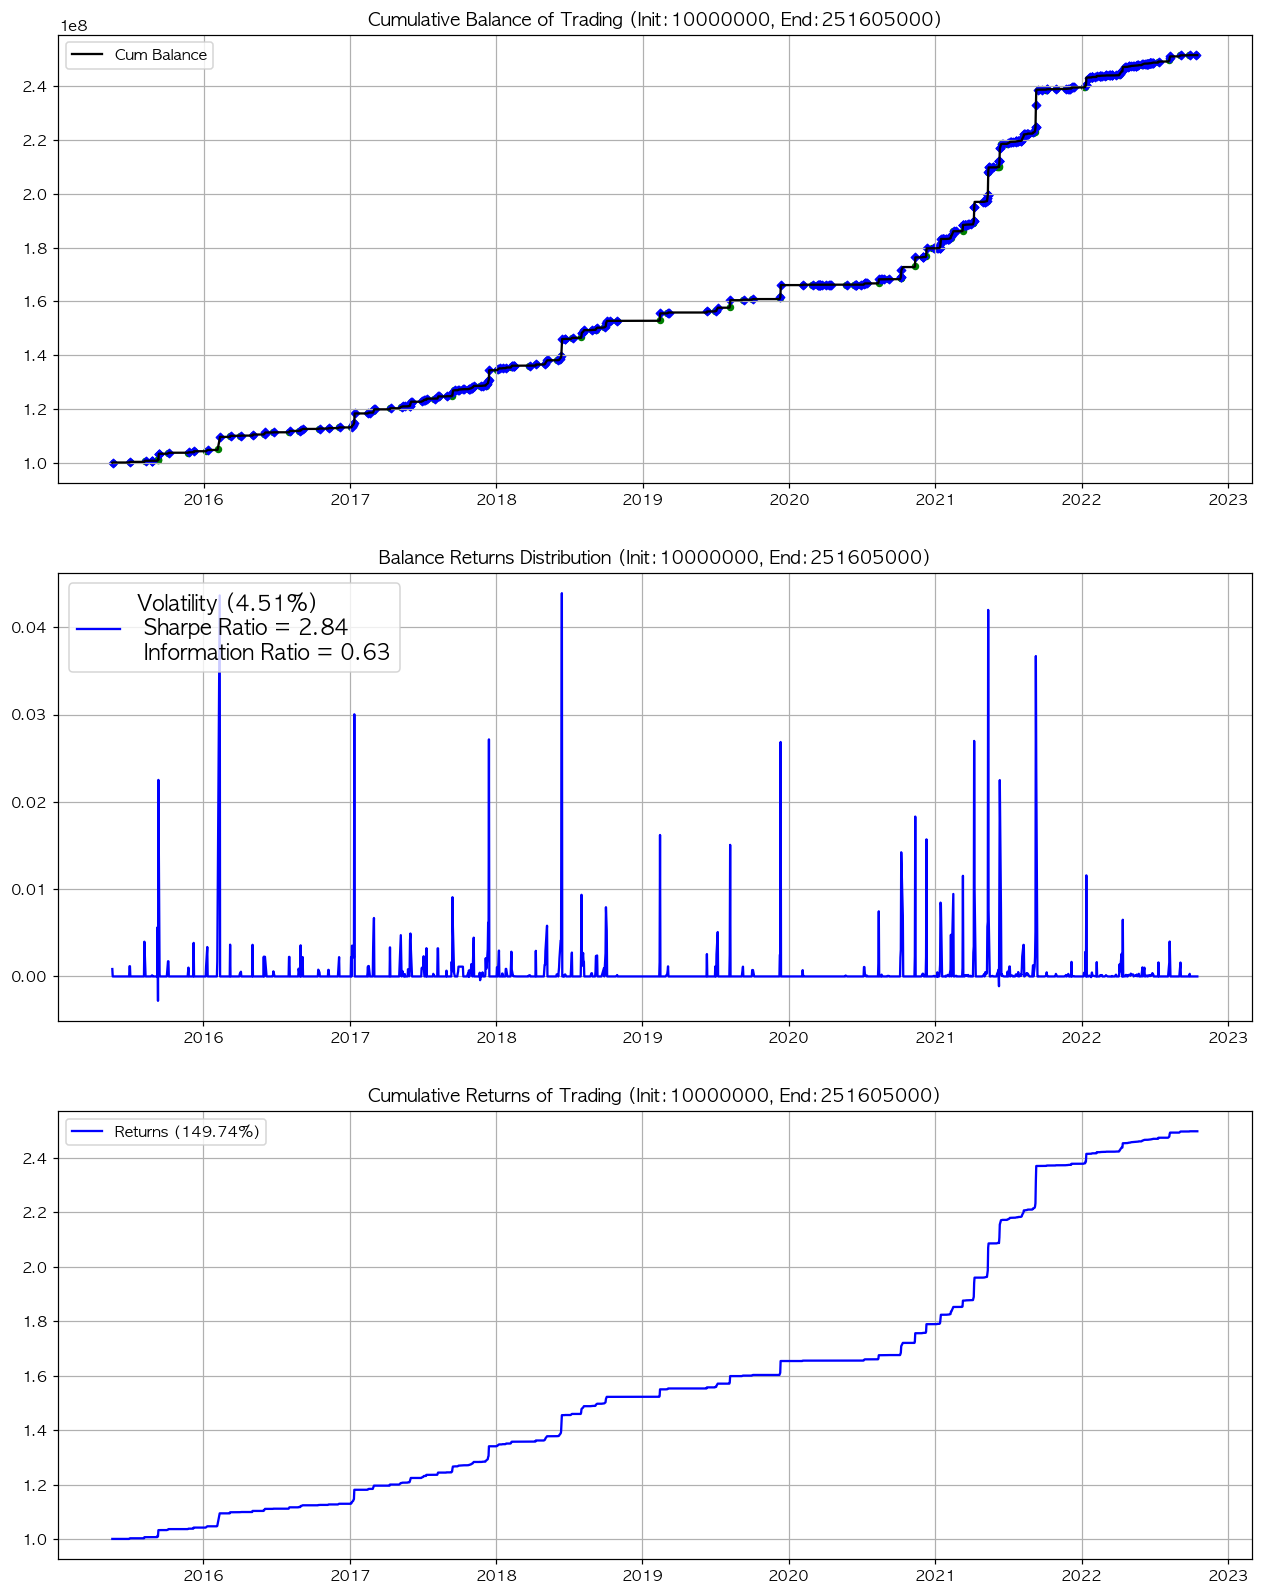

In [12]:
balance_ret_df = pd.DataFrame(data=np.log(pay_off_df).diff().iloc[1:].Balance.values, columns=['Balance Ret'], index=np.log(pay_off_df).diff().iloc[1:].Balance.index)
bm_ret = pd.DataFrame(np.log(kospi200).diff().dropna().loc[balance_ret_df.index])
rf_ret = cd91.loc[balance_ret_df.index]

ann_std = balance_ret_df.std().item() * np.sqrt(252)

cum_ret_df = np.cumprod(1+balance_ret_df)

sharpe = (balance_ret_df.mean().item()) / (balance_ret_df.values).std() * np.sqrt(252)
ir_ratio = (balance_ret_df.mean().item() - bm_ret.mean().item()) / (balance_ret_df.values - bm_ret.values).std() * np.sqrt(252)


plt.figure(figsize=(14, 18), dpi=110)
plt.subplot(3,1,1)
plt.title(f'Cumulative Balance of Trading (Init:10000000, End:{int(balance)})')
plt.plot(pay_off_df.Balance, color='k', label=f'Cum Balance')
plt.scatter(x=holding_reg.Start, y=pay_off_df.Balance.loc[holding_reg.Start.values], color='g', marker='o', s=15)
plt.scatter(x=holding_reg.End, y=pay_off_df.Balance.loc[holding_reg.End.values], color='b', marker='D', s=15)
plt.legend()
plt.grid()


plt.subplot(3,1,2)
plt.title(f'Balance Returns Distribution (Init:10000000, End:{int(balance)})')
plt.plot(balance_ret_df, color='b', \
         label=f'Volatility ({np.round(ann_std * 100, 2)}%)\n Sharpe Ratio = {np.round(sharpe, 2)}\n Information Ratio = {np.round(ir_ratio, 2)}')
plt.legend(fontsize=14)
plt.grid()


plt.subplot(3,1,3)
plt.title(f'Cumulative Returns of Trading (Init:10000000, End:{int(balance)})')
plt.plot(cum_ret_df, color='b', label=f'Returns ({np.round( (cum_ret_df.iloc[-1].item()-1)* 100, 2)}%)')
plt.legend()
plt.grid()
plt.show()



## 3) 수수료 껴서 백테스팅 해보기

한투 수수료 감안

코스피200 옵션


- 1천만원 미만

|가격 구간| 수수료|
|:---:|:---:|
|0.42p 미만 | 13원 + 0.383% |
|0.42p 이상 ~ 2.47p 미만 | 0.4% |
|2.47p 이상 | 78원 + 0.38% |

- 1천만원 이상

|가격 구간| 수수료|
|:---:|:---:|
|0.42p 미만 | 13원 + 0.283% |
|0.42p 이상 ~ 2.47p 미만 | 0.3% |
|2.47p 이상 | 78원 + 0.28% |

In [13]:
def buying_ratio_cal(index, inv_port, budget, mul):
    
    '''1000만원 Exposure 맞추기 / 사서 받는 비용'''
    ratio = p_all_reg[index].loc[inv_port].apply(lambda x: x * 250000).sum()
    buying_num = int(np.floor(budget/ratio))
    
    price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
    price = cal_cost(price * mul)
    
    return ratio * buying_num, buying_num * price, buying_num

def cal_cost(df):
    return df.iloc[0].item() + df.iloc[2].item() - 2 * df.iloc[1].item()

def check_fee (price, mul):
    
    if price < 0.42:
        fee = 13 + price * mul * 0.00383
    elif price < 2.47:
        fee = price * mul * (0.00383)
    elif price >= 2.47:
        fee = 78 + price * mul * (0.00383)
        
    return fee

In [14]:
pay_off_df = pd.DataFrame(columns=['Date', 'Balance', 'Assets'])

hold_p = []
balance = 100000000
budget = 2000000
assets = 0
mul = 250000



for x in g_reg.columns[-1816:]:
    
    idx = x
    s0 = kospi200.loc[idx]    
    print('\n')
    print('*********TRADE DATE*********')
    print(idx)
    
    '''포트폴리오 있을 때 체크'''
    print('---------HOLD PORT---------')
    print(hold_p)
    
    if len(hold_p) == 0:
        pass
    else:
        print('---------Individual Hold Port---------')
        for values_str in hold_p:
            
            values = float(values_str.split('|')[0])
            num = int(values_str.split('|')[1])

            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            price = pd.DataFrame(p_all_reg[idx].loc[inv_port])            
            price = cal_cost(price * mul)
            
            price = price * num
            
            fee = pd.DataFrame(p_all_reg[idx].loc[inv_port])[idx].apply(lambda x: check_fee(x, mul)).sum()
            fee = fee * num
            
            print(f'{values} : {price}')
            print(f'{values} fee : {fee}')
            
            '''가격 balance에 넣고 빼기'''
            # balance += -price
            # assets += -price
            balance += price -fee
            assets += price - fee  
            
        '''g값을 확인해서 청산여부 체크하기'''
        print('---------Individual Close Check---------')
        for values_str in hold_p:
            
            values = float(values_str.split('|')[0])
            num = int(values_str.split('|')[1])
            
            if g_reg[idx].loc[values] < 0 :
                pass
            
            elif g_reg[idx].loc[values] >= 0 :
                # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                # ful_arr = nan_arr[~np.isnan(nan_arr)]
                # hold_p = list(ful_arr)
                
                hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                hold_p.pop(hold_p_idx)

                print(f'{values} : {g_reg[idx].loc[values]}')
            
            elif pd.isna(g_reg[idx].loc[values]) == True :
                
                # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                # ful_arr = nan_arr[~np.isnan(nan_arr)]
                # hold_p = list(ful_arr)
                
                hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                hold_p.pop(hold_p_idx)
                
                print(f'{values} : {g_reg[idx].loc[values]}')
                
    '''당일의 포트폴리오 추가'''
    if idx in b_df.index.values:
        print('---------Buying Port Check---------')

        '''포트폴리오 구축 비용 생각 + 저장'''
        for values in b_df.loc[idx].values[0]:
 
            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            
            # price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
            # price = cal_cost(price * mul)
            
            margin, price, num = buying_ratio_cal(idx, inv_port, budget, mul)
            
            '''Fee 계산'''
            fee = pd.DataFrame(p_all_reg[idx].loc[inv_port])[idx].apply(lambda x: check_fee(x, mul)).sum()
            fee = fee * num
            
            print(f'{values} : {price} / {num}')
            print(f'{values} fee : {fee}')
            
            '''포트폴리오에 추가'''
            hold_p.append(str(values) + str('|') + str(num))
            
            '''balance에 추가, 돈 받고 산거임, 따라서 음수'''
            # balance += -price
            # assets += -price
            balance += -price -fee
            assets += -price - fee 
                       
    else:
        pass
    
    '''저장'''
    pay_off_df = pd.concat([pay_off_df, pd.DataFrame([idx, balance, assets], index=['Date', 'Balance', 'Assets']).T])

pay_off_df = pay_off_df.fillna(method='ffill').set_index('Date')
    



*********TRADE DATE*********
2015-05-18 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-19 00:00:00
---------HOLD PORT---------
[]
---------Buying Port Check---------
242.5 : -85000.0 / 34
242.5 fee : 8813.650000000001


*********TRADE DATE*********
2015-05-20 00:00:00
---------HOLD PORT---------
['242.5|34']
---------Individual Hold Port---------
242.5 : 0.0
242.5 fee : 6209.25
---------Individual Close Check---------
242.5 : 0.0


*********TRADE DATE*********
2015-05-21 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-22 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-26 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-27 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-28 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-05-29 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-06-0

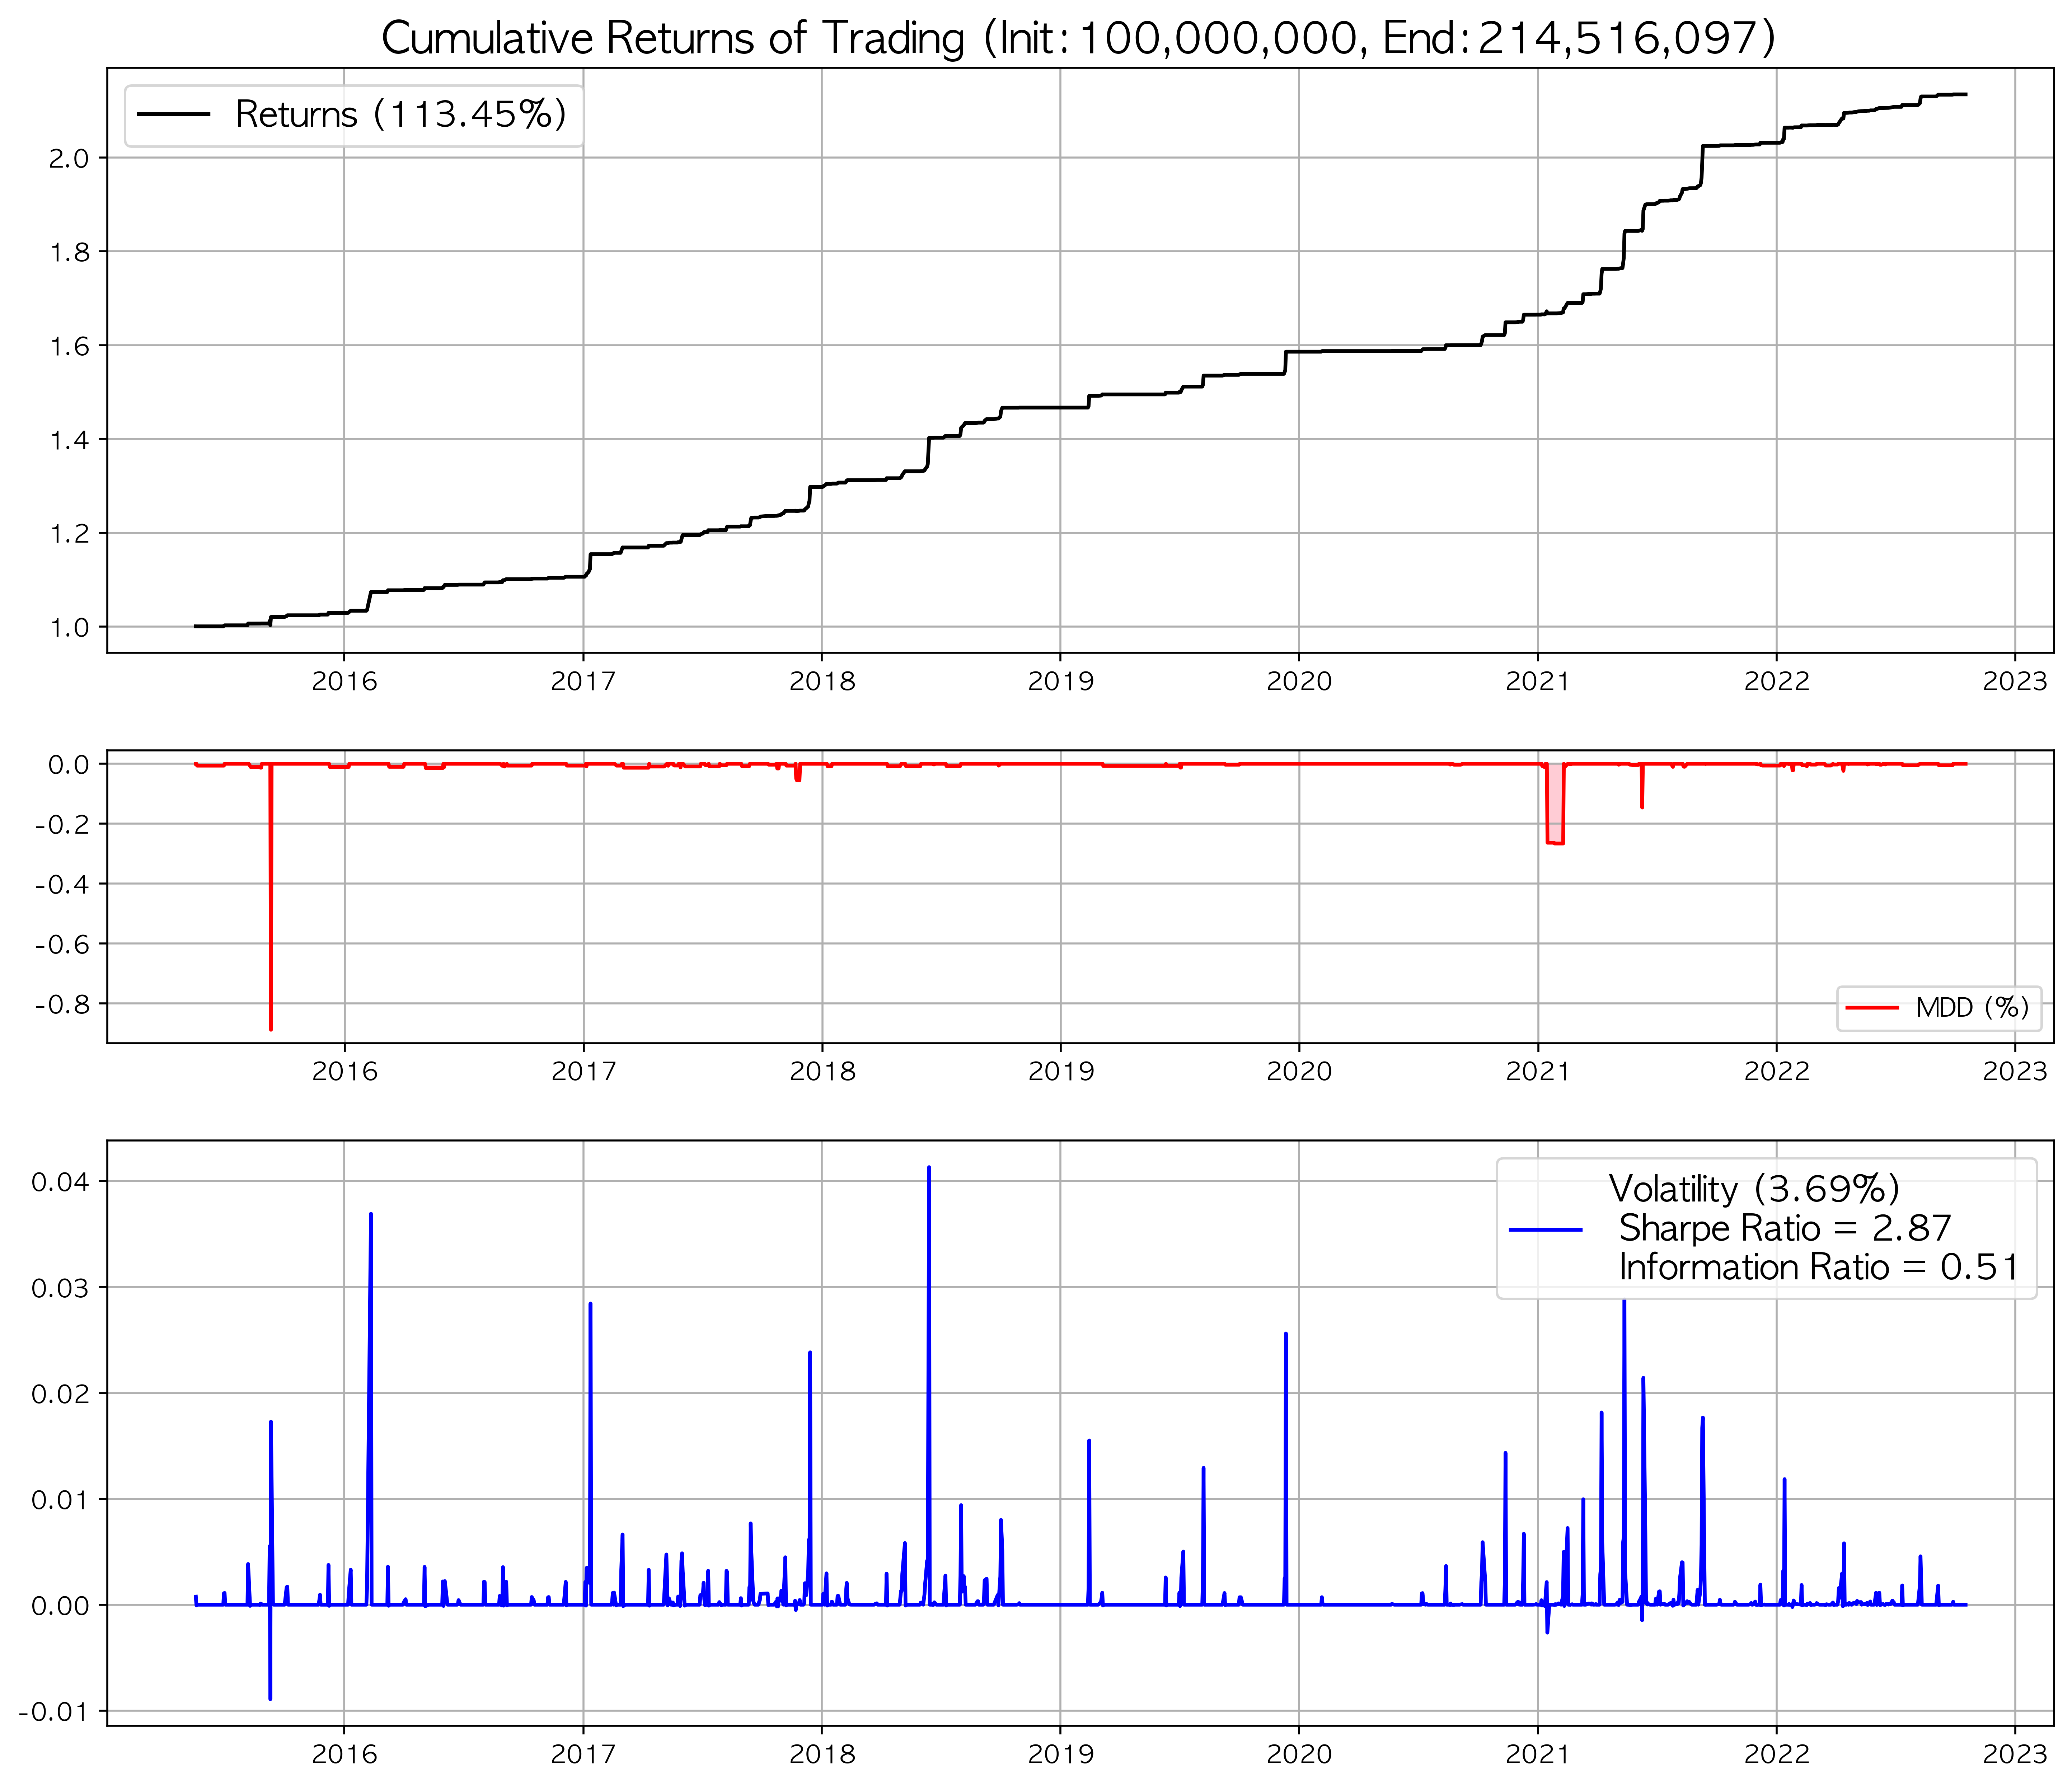

In [21]:
balance_ret_df = pd.DataFrame(data=np.log(pay_off_df).diff().iloc[1:].Balance.values, columns=['Balance Ret'], index=np.log(pay_off_df).diff().iloc[1:].Balance.index)
bm_ret = pd.DataFrame(np.log(kospi200).diff().dropna().loc[balance_ret_df.index])
rf_ret = cd91.loc[balance_ret_df.index]

ann_std = balance_ret_df.std().item() * np.sqrt(252)

cum_ret_df = np.cumprod(1+balance_ret_df)

sharpe = (balance_ret_df.mean().item()) / (balance_ret_df.values).std() * np.sqrt(252)
ir_ratio = (balance_ret_df.mean().item() - bm_ret.mean().item()) / (balance_ret_df.values - bm_ret.values).std() * np.sqrt(252)
'''mdd'''
mdd = get_mdd(pay_off_df.Balance)


fig, axes = plt.subplots(3,1,figsize=(14,12), dpi=500, gridspec_kw={'height_ratios': [2, 1, 2]})

axes[0].set_title(f"Cumulative Returns of Trading (Init:100,000,000, End:{format(round(balance), ',')})", size=17)
axes[0].plot(cum_ret_df, color='k', label=f'Returns ({np.round( (cum_ret_df.iloc[-1].item()-1)* 100, 2)}%)')
#axes[0].scatter(x=holding_reg.Start, y=pay_off_df.Balance.loc[holding_reg.Start.values], color='g', marker='o', s=15)
#axes[0].scatter(x=holding_reg.End, y=pay_off_df.Balance.loc[holding_reg.End.values], color='b', marker='D', s=15)
axes[0].legend(fontsize=14)
axes[0].grid()

axes[1].plot(mdd, color='r', label='MDD (%)')
#axes[1].set_title(f'Cumulative Returns of Trading (Init:10000000, End:{balance})')
axes[1].fill_between(mdd.index, mdd.to_numpy().reshape(-1), color='pink', alpha=0.8)
#axes[1].set_ylim(-0, 0)
axes[1].legend()
axes[1].grid()

axes[2].plot(balance_ret_df, color='b', \
         label=f'Volatility ({np.round(ann_std * 100, 2)}%)\n Sharpe Ratio = {np.round(sharpe, 2)}\n Information Ratio = {np.round(ir_ratio, 2)}')
axes[2].legend(fontsize=14)
axes[2].grid()

plt.show()

### 3-1) 연간으로 뽑아보기

In [22]:
g_reg.columns.year.unique()

Int64Index([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
            2018, 2019, 2020, 2021, 2022],
           dtype='int64')

In [26]:
year_idx_arr = g_reg.columns.year.unique()[8:]
year_stats_df = pd.DataFrame(index=year_idx_arr, columns=['ret', 'sharpe', 'ir', 'vol', 'trading_date'])

    #year_test = g_reg.T.loc[str(year_idx)].T
        #for x in g_reg.columns[-1816:]:

for year_idx in year_idx_arr:
    
    pay_off_df = pd.DataFrame(columns=['Date', 'Balance', 'Assets'])

    hold_p = []
    balance = 100000000
    budget = 2000000
    assets = 0
    mul = 250000
    
    year_test = g_reg.T.loc[str(year_idx)].T
    holding_date_count = 0
    
    for x in year_test.columns:
            
        idx = x
        s0 = kospi200.loc[idx]    
        
        print('\n')
        print('*********TRADE DATE*********')
        print(idx)
        
        '''포트폴리오 있을 때 체크'''
        print('---------HOLD PORT---------')
        print(hold_p)
        
        if len(hold_p) == 0:
            hold_status = 0
            pass
        else:
            print('---------Individual Hold Port---------')
            holding_date_count += 1
            hold_status = 1
            
            for values_str in hold_p:
                
                values = float(values_str.split('|')[0])
                num = int(values_str.split('|')[1])

                p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
                inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
                price = pd.DataFrame(p_all_reg[idx].loc[inv_port])            
                price = cal_cost(price * mul)
                
                price = price * num
                
                fee = pd.DataFrame(p_all_reg[idx].loc[inv_port])[idx].apply(lambda x: check_fee(x, mul)).sum()
                fee = fee * num
                
                print(f'{values} : {price}')
                print(f'{values} fee : {fee}')
                
                '''가격 balance에 넣고 빼기'''
                # balance += -price
                # assets += -price
                balance += price -fee
                assets += price - fee  
                
            '''g값을 확인해서 청산여부 체크하기'''
            print('---------Individual Close Check---------')
            for values_str in hold_p:
                
                values = float(values_str.split('|')[0])
                num = int(values_str.split('|')[1])
                
                if g_reg[idx].loc[values] < 0 :
                    pass
                
                elif g_reg[idx].loc[values] >= 0 :
                    # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                    # ful_arr = nan_arr[~np.isnan(nan_arr)]
                    # hold_p = list(ful_arr)
                    
                    hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                    hold_p.pop(hold_p_idx)

                    print(f'{values} : {g_reg[idx].loc[values]}')
                
                elif pd.isna(g_reg[idx].loc[values]) == True :
                    
                    # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                    # ful_arr = nan_arr[~np.isnan(nan_arr)]
                    # hold_p = list(ful_arr)
                    
                    hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                    hold_p.pop(hold_p_idx)
                    
                    print(f'{values} : {g_reg[idx].loc[values]}')
                    
        '''당일의 포트폴리오 추가'''
        if idx in b_df.index.values:
            print('---------Buying Port Check---------')
            
            if hold_status == 0:
                holding_date_count += 1
            else:
                pass

            '''포트폴리오 구축 비용 생각 + 저장'''
            for values in b_df.loc[idx].values[0]:

                p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
                inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
                
                # price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
                # price = cal_cost(price * mul)
                
                margin, price, num = buying_ratio_cal(idx, inv_port, budget, mul)
                
                '''Fee 계산'''
                fee = pd.DataFrame(p_all_reg[idx].loc[inv_port])[idx].apply(lambda x: check_fee(x, mul)).sum()
                fee = fee * num
                
                print(f'{values} : {price} / {num}')
                print(f'{values} fee : {fee}')
                
                '''포트폴리오에 추가'''
                hold_p.append(str(values) + str('|') + str(num))
                
                '''balance에 추가, 돈 받고 산거임, 따라서 음수'''
                # balance += -price
                # assets += -price
                balance += -price -fee
                assets += -price - fee 
                        
        else:
            pass
        
        '''저장'''
        pay_off_df = pd.concat([pay_off_df, pd.DataFrame([idx, balance, assets], index=['Date', 'Balance', 'Assets']).T])

    '''payoff df 만들기'''
    pay_off_df = pay_off_df.fillna(method='ffill').set_index('Date')

    '''return payoff df 만들고, 필요 통계량 만들기'''
    balance_ret_df = pd.DataFrame(data=np.log(pay_off_df).diff().iloc[1:].Balance.values, columns=['Balance Ret'], index=np.log(pay_off_df).diff().iloc[1:].Balance.index)
    bm_ret = pd.DataFrame(np.log(kospi200).diff().dropna().loc[balance_ret_df.index])
    rf_ret = cd91.loc[balance_ret_df.index]

    '''변동성'''
    ann_std = balance_ret_df.std().item() * np.sqrt(252)
    '''누적 수익률'''
    cum_ret_df = np.cumprod(1+balance_ret_df)
    cum_ret_reg = np.round( (cum_ret_df.iloc[-1].item()-1)* 100, 2)
    '''평가지표'''
    sharpe = (balance_ret_df.mean().item()) / (balance_ret_df.values).std() * np.sqrt(252)
    ir_ratio = (balance_ret_df.mean().item() - bm_ret.mean().item()) / (balance_ret_df.values - bm_ret.values).std() * np.sqrt(252)

    year_stats_df.loc[year_idx] = [cum_ret_reg, sharpe, ir_ratio, ann_std, int(holding_date_count)]
    year_stats_df



*********TRADE DATE*********
2015-01-02 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-05 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-06 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-07 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-08 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-09 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-12 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-13 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-14 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-15 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-16 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2015-01-19 00:00:00
---------HOLD PORT---------
[]


*********TRADE

NameError: name 'b_all_df' is not defined

In [ ]:
year_stats_df.ir = year_stats_df.ir.apply(lambda x: np.round(x,2))
year_stats_df.sharpe = year_stats_df.sharpe.apply(lambda x: np.round(x,2))
year_stats_df.vol = year_stats_df.vol.apply(lambda x: np.round(x*100,2))

In [ ]:
aa = pd.DataFrame(year_stats_df.mean()).T
aa.index = ['Mean']

In [ ]:
np.round(aa,2)

,ret,sharpe,ir,vol,trading_date
Mean,14.6,3.05,0.75,4.5,63.88


In [ ]:
year_stats_df

,ret,sharpe,ir,vol,trading_date
2015,6.32,2.66,0.61,2.37,34
2016,7.7,1.96,-0.20,3.97,30
2017,19.15,4.05,-0.33,4.64,80
2018,16.9,2.82,2.32,5.81,56
2019,11.91,2.41,-0.11,4.86,21
2020,7.91,2.74,-0.76,2.85,61
2021,36.6,4.03,1.74,7.99,131
2022,10.33,3.76,2.74,3.50,98


In [ ]:
pd.concat([year_stats_df, np.round(aa,2)])

,ret,sharpe,ir,vol,trading_date
2015,6.32,2.66,0.61,2.37,34
2016,7.7,1.96,-0.20,3.97,30
2017,19.15,4.05,-0.33,4.64,80
2018,16.9,2.82,2.32,5.81,56
2019,11.91,2.41,-0.11,4.86,21
2020,7.91,2.74,-0.76,2.85,61
2021,36.6,4.03,1.74,7.99,131
2022,10.33,3.76,2.74,3.50,98
Mean,14.6,3.05,0.75,4.50,63.88


In [ ]:
bb = pd.concat([year_stats_df, np.round(aa,2)])
bb.vol = bb.vol.astype(str) + '%'

bb

,ret,sharpe,ir,vol,trading_date
2015,6.32,2.66,0.61,2.37%,34
2016,7.7,1.96,-0.20,3.97%,30
2017,19.15,4.05,-0.33,4.64%,80
2018,16.9,2.82,2.32,5.81%,56
2019,11.91,2.41,-0.11,4.86%,21
2020,7.91,2.74,-0.76,2.85%,61
2021,36.6,4.03,1.74,7.99%,131
2022,10.33,3.76,2.74,3.5%,98
Mean,14.6,3.05,0.75,4.5%,63.88


### 특정 year 뽑아보기

In [ ]:
year_idx_arr = g_reg.columns.year.unique()[1:]
year_stats_df = pd.DataFrame(index=year_idx_arr, columns=['ret', 'sharpe', 'ir', 'vol', 'trading_date'])

    #year_test = g_reg.T.loc[str(year_idx)].T
        #for x in g_reg.columns[-1816:]:

#for year_idx in year_idx_arr:
year_idx = 2022
pay_off_df = pd.DataFrame(columns=['Date', 'Balance', 'Assets'])

hold_p = []
balance = 100000000
budget = 2000000
assets = 0
mul = 250000

year_test = g_reg.T.loc[str(year_idx)].T
holding_date_count = 0

for x in year_test.columns:
        
    idx = x
    s0 = kospi200.loc[idx]    
    
    print('\n')
    print('*********TRADE DATE*********')
    print(idx)
    
    '''포트폴리오 있을 때 체크'''
    print('---------HOLD PORT---------')
    print(hold_p)
    
    if len(hold_p) == 0:
        hold_status = 0
        pass
    else:
        print('---------Individual Hold Port---------')
        holding_date_count += 1
        hold_status = 1
        
        for values_str in hold_p:
            
            values = float(values_str.split('|')[0])
            num = int(values_str.split('|')[1])

            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            price = pd.DataFrame(p_all_reg[idx].loc[inv_port])            
            price = cal_cost(price * mul)
            
            price = price * num
            
            fee = pd.DataFrame(p_all_reg[idx].loc[inv_port])[idx].apply(lambda x: check_fee(x, mul)).sum()
            fee = fee * num
            
            print(f'{values} : {price}')
            print(f'{values} fee : {fee}')
            
            '''가격 balance에 넣고 빼기'''
            # balance += -price
            # assets += -price
            balance += price -fee
            assets += price - fee  
            
        '''g값을 확인해서 청산여부 체크하기'''
        print('---------Individual Close Check---------')
        for values_str in hold_p:
            
            values = float(values_str.split('|')[0])
            num = int(values_str.split('|')[1])
            
            if g_reg[idx].loc[values] < 0 :
                pass
            
            elif g_reg[idx].loc[values] >= 0 :
                # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                # ful_arr = nan_arr[~np.isnan(nan_arr)]
                # hold_p = list(ful_arr)
                
                hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                hold_p.pop(hold_p_idx)

                print(f'{values} : {g_reg[idx].loc[values]}')
            
            elif pd.isna(g_reg[idx].loc[values]) == True :
                
                # nan_arr = np.where(np.array(hold_p) == values, np.NaN, hold_p)
                # ful_arr = nan_arr[~np.isnan(nan_arr)]
                # hold_p = list(ful_arr)
                
                hold_p_idx = np.where(np.array([float(x.split('|')[0]) for x in hold_p]) == values)[0][0]
                hold_p.pop(hold_p_idx)
                
                print(f'{values} : {g_reg[idx].loc[values]}')
                
    '''당일의 포트폴리오 추가'''
    if idx in b_all_df.index.values:
        print('---------Buying Port Check---------')
        
        if hold_status == 0:
            holding_date_count += 1
        else:
            pass

        '''포트폴리오 구축 비용 생각 + 저장'''
        for values in b_all_df.loc[idx].values[0]:

            p_inst = sliding_window_view( p_all_reg[idx].index, 3 )
            inv_port = p_inst[np.where(p_inst[:,0] == values)[0][0]]
            
            # price = pd.DataFrame(p_all_reg[idx].loc[inv_port])
            # price = cal_cost(price * mul)
            
            margin, price, num = buying_ratio_cal(idx, inv_port, budget, mul)
            
            '''Fee 계산'''
            fee = pd.DataFrame(p_all_reg[idx].loc[inv_port])[idx].apply(lambda x: check_fee(x, mul)).sum()
            fee = fee * num
            
            print(f'{values} : {price} / {num}')
            print(f'{values} fee : {fee}')
            
            '''포트폴리오에 추가'''
            hold_p.append(str(values) + str('|') + str(num))
            
            '''balance에 추가, 돈 받고 산거임, 따라서 음수'''
            # balance += -price
            # assets += -price
            balance += -price -fee
            assets += -price - fee 
                    
    else:
        pass
    
    '''저장'''
    pay_off_df = pd.concat([pay_off_df, pd.DataFrame([idx, balance, assets], index=['Date', 'Balance', 'Assets']).T])

'''payoff df 만들기'''
pay_off_df = pay_off_df.fillna(method='ffill').set_index('Date')

'''return payoff df 만들고, 필요 통계량 만들기'''
balance_ret_df = pd.DataFrame(data=np.log(pay_off_df).diff().iloc[1:].Balance.values, columns=['Balance Ret'], index=np.log(pay_off_df).diff().iloc[1:].Balance.index)
bm_ret = pd.DataFrame(np.log(kospi200).diff().dropna().loc[balance_ret_df.index])
rf_ret = cd91.loc[balance_ret_df.index]

'''변동성'''
ann_std = balance_ret_df.std().item() * np.sqrt(252)
'''누적 수익률'''
cum_ret_df = np.cumprod(1+balance_ret_df)
cum_ret_reg = np.round( (cum_ret_df.iloc[-1].item()-1)* 100, 2)
'''평가지표'''
sharpe = (balance_ret_df.mean().item()) / (balance_ret_df.values).std() * np.sqrt(252)
ir_ratio = (balance_ret_df.mean().item() - bm_ret.mean().item()) / (balance_ret_df.values - bm_ret.values).std() * np.sqrt(252)

year_stats_df.loc[year_idx] = [cum_ret_reg, sharpe, ir_ratio, ann_std, int(holding_date_count)]
year_stats_df



*********TRADE DATE*********
2022-01-04 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2022-01-05 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2022-01-06 00:00:00
---------HOLD PORT---------
[]


*********TRADE DATE*********
2022-01-07 00:00:00
---------HOLD PORT---------
[]
---------Buying Port Check---------
360.0 : -100000.0 / 40
360.0 fee : 9220.0


*********TRADE DATE*********
2022-01-10 00:00:00
---------HOLD PORT---------
['360.0|40']
---------Individual Hold Port---------
360.0 : -100000.0
360.0 fee : 5773.0
---------Individual Close Check---------
---------Buying Port Check---------
360.0 : -180000.0 / 72
360.0 fee : 10391.4


*********TRADE DATE*********
2022-01-11 00:00:00
---------HOLD PORT---------
['360.0|40', '360.0|72']
---------Individual Hold Port---------
360.0 : 100000.0
360.0 fee : 3092.0
360.0 : 180000.0
360.0 fee : 5565.599999999999
---------Individual Close Check---------
360.0 : 0.0016
---------Buying Port Che

,ret,sharpe,ir,vol,trading_date
2008,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN
2014,NaN,NaN,NaN,NaN,NaN
2015,NaN,NaN,NaN,NaN,NaN
2016,NaN,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN


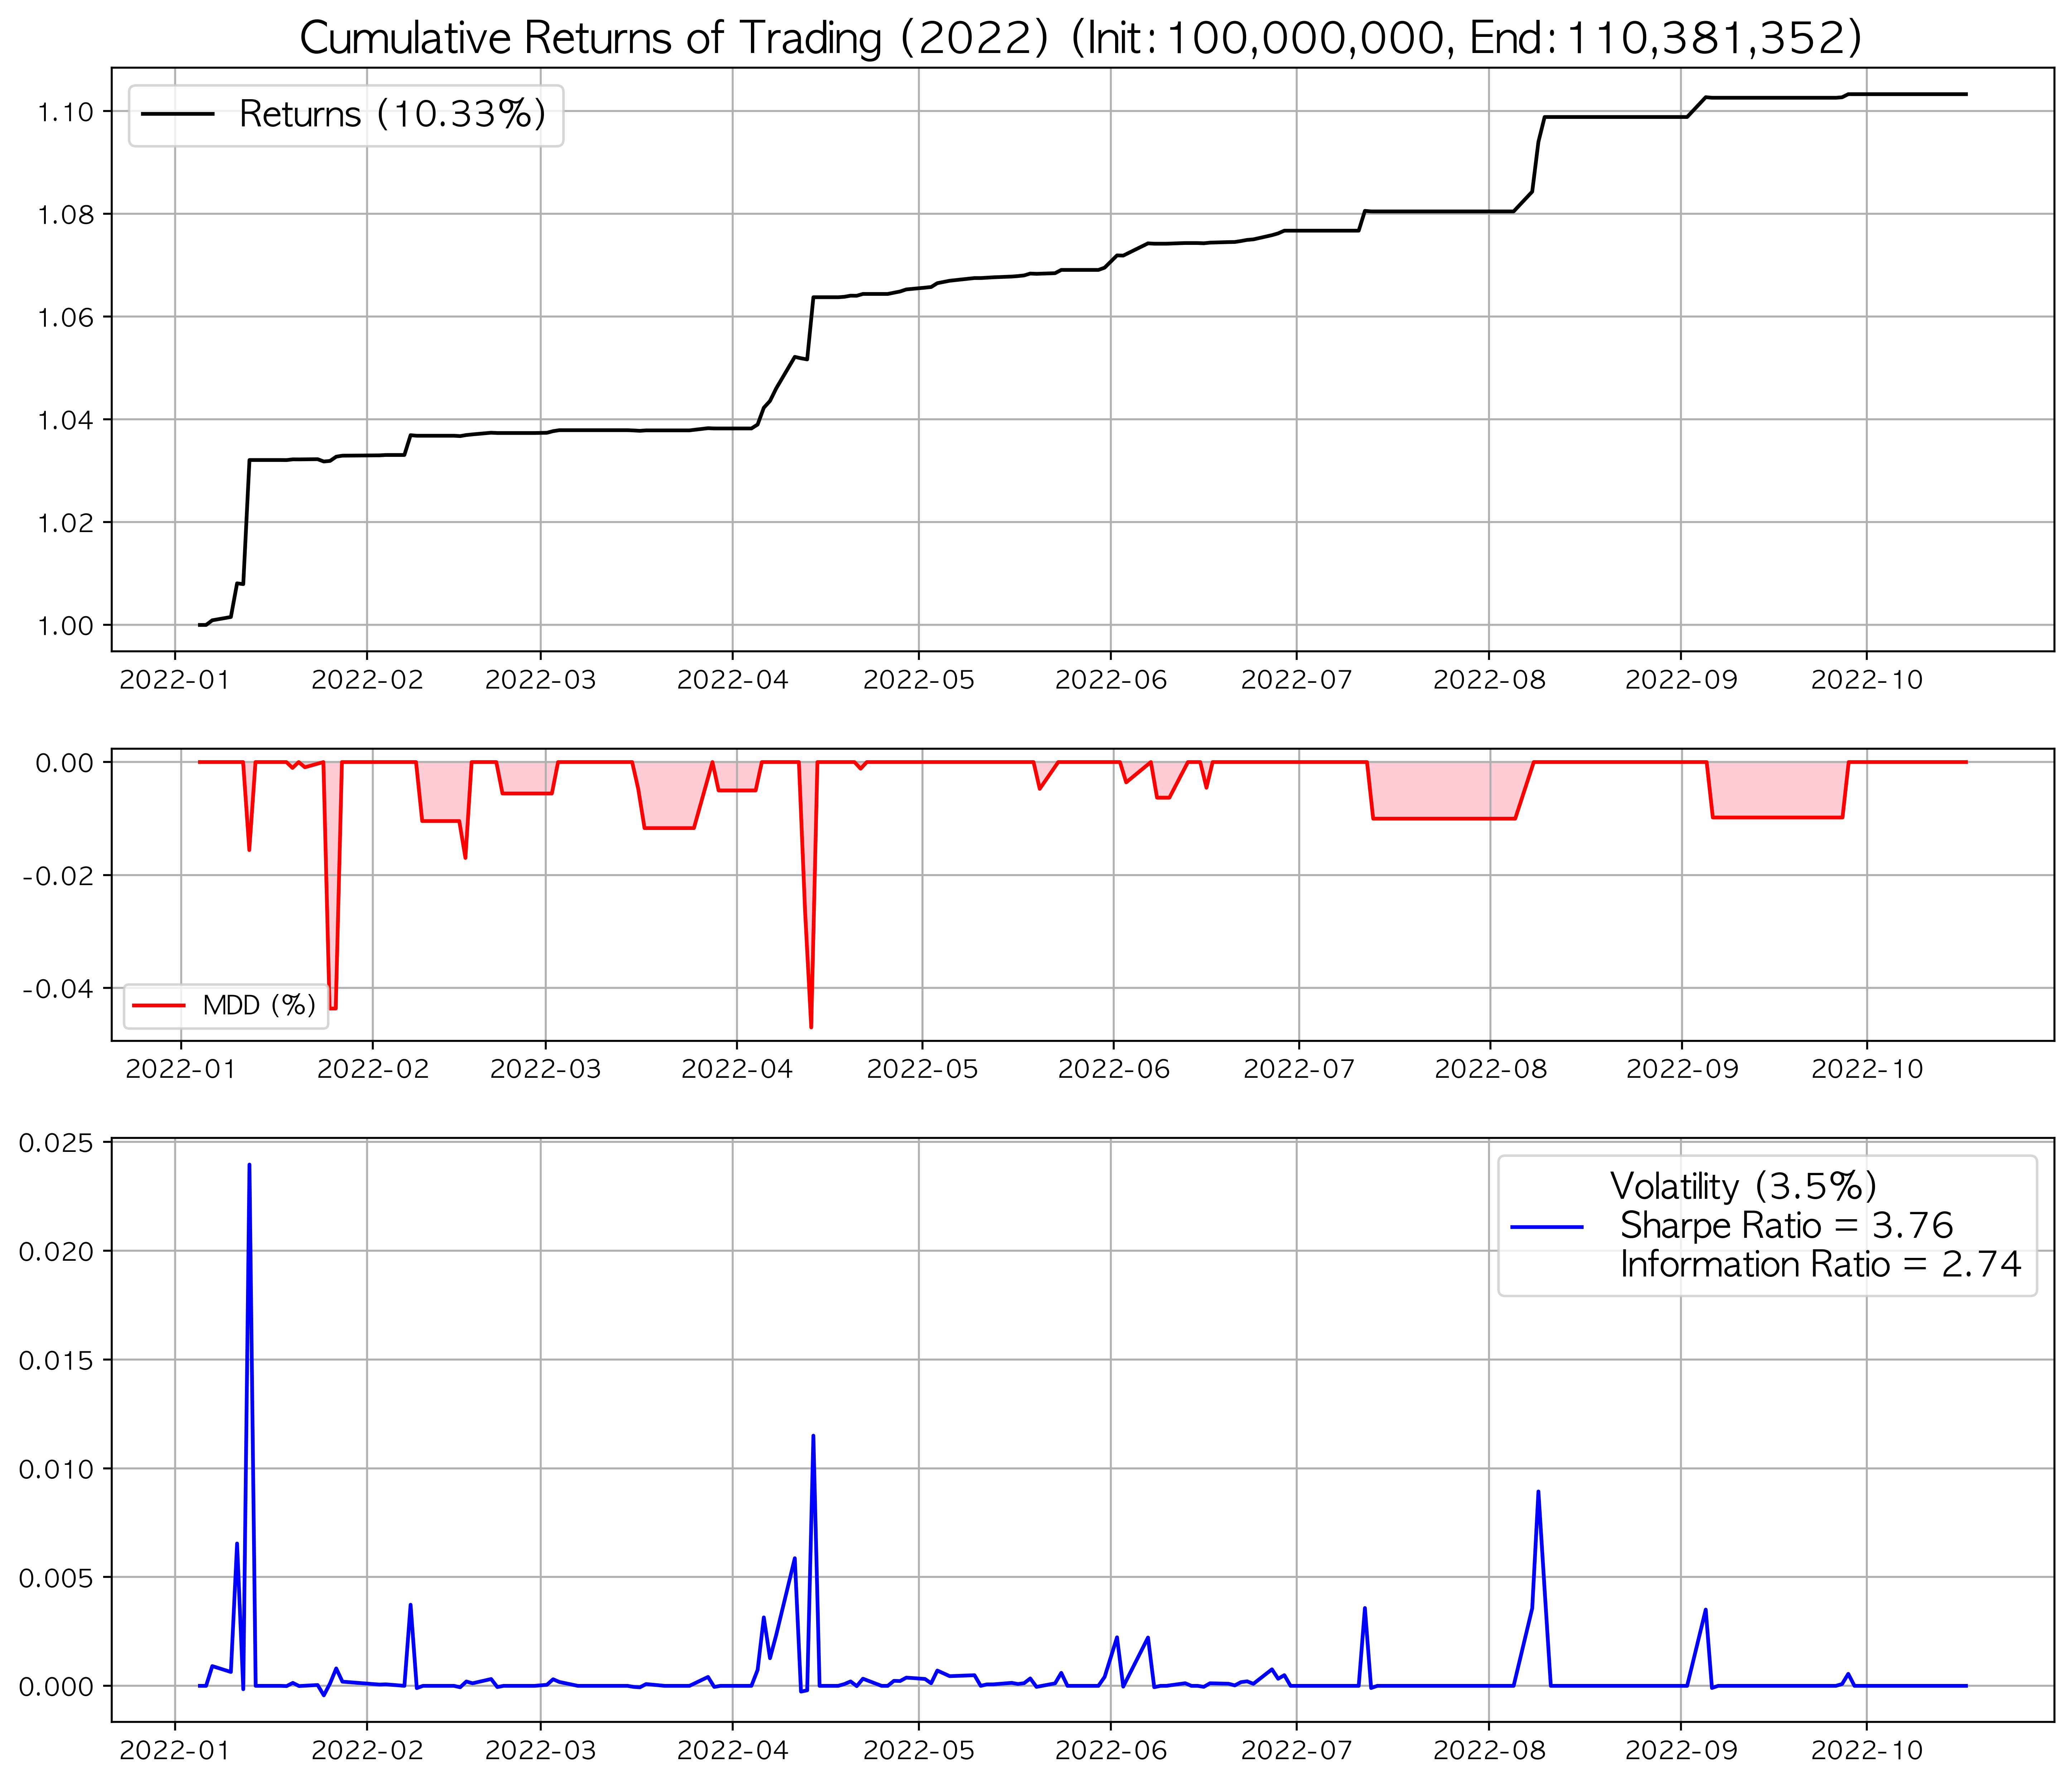

In [ ]:
balance_ret_df = pd.DataFrame(data=np.log(pay_off_df).diff().iloc[1:].Balance.values, columns=['Balance Ret'], index=np.log(pay_off_df).diff().iloc[1:].Balance.index)
bm_ret = pd.DataFrame(np.log(kospi200).diff().dropna().loc[balance_ret_df.index])
rf_ret = cd91.loc[balance_ret_df.index]

ann_std = balance_ret_df.std().item() * np.sqrt(252)

cum_ret_df = np.cumprod(1+balance_ret_df)

sharpe = (balance_ret_df.mean().item()) / (balance_ret_df.values).std() * np.sqrt(252)
ir_ratio = (balance_ret_df.mean().item() - bm_ret.mean().item()) / (balance_ret_df.values - bm_ret.values).std() * np.sqrt(252)
'''mdd'''
mdd = get_mdd(pay_off_df.Balance)


fig, axes = plt.subplots(3,1,figsize=(14,12), dpi=500, gridspec_kw={'height_ratios': [2, 1, 2]})

axes[0].set_title(f"Cumulative Returns of Trading (2022) (Init:100,000,000, End:{format(round(balance), ',')})", size=17)
axes[0].plot(cum_ret_df, color='k', label=f'Returns ({np.round( (cum_ret_df.iloc[-1].item()-1)* 100, 2)}%)')
#axes[0].scatter(x=holding_reg.Start, y=pay_off_df.Balance.loc[holding_reg.Start.values], color='g', marker='o', s=15)
#axes[0].scatter(x=holding_reg.End, y=pay_off_df.Balance.loc[holding_reg.End.values], color='b', marker='D', s=15)
axes[0].legend(fontsize=14)
axes[0].grid()

axes[1].plot(mdd, color='r', label='MDD (%)')
#axes[1].set_title(f'Cumulative Returns of Trading (Init:10000000, End:{balance})')
axes[1].fill_between(mdd.index, mdd.to_numpy().reshape(-1), color='pink', alpha=0.8)
#axes[1].set_ylim(-0, 0)
axes[1].legend()
axes[1].grid()

axes[2].plot(balance_ret_df, color='b', \
         label=f'Volatility ({np.round(ann_std * 100, 2)}%)\n Sharpe Ratio = {np.round(sharpe, 2)}\n Information Ratio = {np.round(ir_ratio, 2)}')
axes[2].legend(fontsize=14)
axes[2].grid()

plt.show()